# Goal

To extract feature importances from PCA components

### In Python

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

In [78]:
df = pd.read_csv("/Users/spurushe/Documents/data-science-world/input_data/iris.csv", header=0)

In [79]:
df = df.drop(columns="Id", axis = 1)
df.Species = pd.Categorical(df.Species)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [80]:
X = df.drop(columns=["Species"], axis=1)
y = df.Species

In [81]:
sc = StandardScaler()

train_sc = sc.fit(X).transform(X)

In [70]:
from sklearn.decomposition import PCA

In [82]:
pca = PCA()

pca_features = pca.fit(train_sc).transform(train_sc)

In [83]:
pca.explained_variance_ratio_

array([0.72962445, 0.22850762, 0.03668922, 0.00517871])

In [84]:
abs(pca.components_)

array([[0.52106591, 0.26934744, 0.5804131 , 0.56485654],
       [0.37741762, 0.92329566, 0.02449161, 0.06694199],
       [0.71956635, 0.24438178, 0.14212637, 0.63427274],
       [0.26128628, 0.12350962, 0.80144925, 0.52359713]])

In [85]:
col_sums = np.sum(abs(pca.components_), axis=1)
col_sums.reshape(-1,1)

array([[1.93568299],
       [1.39214687],
       [1.74034724],
       [1.70984228]])

In [86]:
rel_importance = abs(pca.components_)/col_sums.reshape(-1,1)

In [87]:
pd.DataFrame(rel_importance, columns= X.columns)

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,0.269190,0.139149,0.299849,0.291813
1,0.271105,0.663217,0.017593,0.048085
2,0.413461,0.140421,0.081666,0.364452
3,0.152813,0.072235,0.468727,0.306225


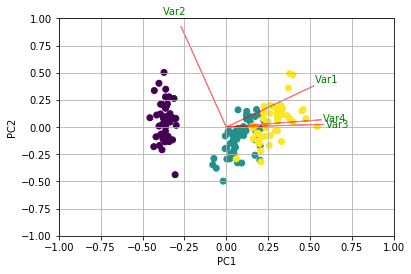

In [89]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c=y.cat.codes)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(pca_features[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

<br/>
<br/>
<br/>
<br/>


### In SPARK

In [90]:
import findspark
findspark.init()

In [91]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as pyf
from pyspark.sql.types import *
import functools

from pyspark.ml import Pipeline
from pyspark.ml.feature import RobustScaler, VectorAssembler, Imputer, StringIndexer,OneHotEncoder, PCA


from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import matplotlib.pyplot as plt
import seaborn as sns 

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [92]:
spark = SparkSession\
        .builder\
        .master("local[4]") \
        .appName("churn_pred")\
        .config('spark.driver.memory', '5G')\
        .config('spark.executor.memory', '7G')\
        .getOrCreate()

In [94]:
sp_df = spark.read.format("csv").load("/Users/spurushe/Documents/data-science-world/input_data/iris.csv", inferSchema ="true", header="true")

In [96]:
sp_df.show(5)

+---+-----------+----------+-----------+----------+-------+
| Id|SepalLength|SepalWidth|PetalLength|PetalWidth|Species|
+---+-----------+----------+-----------+----------+-------+
|  1|        5.1|       3.5|        1.4|       0.2| setosa|
|  2|        4.9|       3.0|        1.4|       0.2| setosa|
|  3|        4.7|       3.2|        1.3|       0.2| setosa|
|  4|        4.6|       3.1|        1.5|       0.2| setosa|
|  5|        5.0|       3.6|        1.4|       0.2| setosa|
+---+-----------+----------+-----------+----------+-------+
only showing top 5 rows



In [100]:
X = sp_df.select('SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth')
y = sp_df.select('Species')

In [102]:
num_cols = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']

In [104]:
va = VectorAssembler(inputCols=num_cols, outputCol='assembled_features')
X = va.transform(X)
X.show(4)

+-----------+----------+-----------+----------+------------------+
|SepalLength|SepalWidth|PetalLength|PetalWidth|assembled_features|
+-----------+----------+-----------+----------+------------------+
|        5.1|       3.5|        1.4|       0.2| [5.1,3.5,1.4,0.2]|
|        4.9|       3.0|        1.4|       0.2| [4.9,3.0,1.4,0.2]|
|        4.7|       3.2|        1.3|       0.2| [4.7,3.2,1.3,0.2]|
|        4.6|       3.1|        1.5|       0.2| [4.6,3.1,1.5,0.2]|
+-----------+----------+-----------+----------+------------------+
only showing top 4 rows



In [105]:
from pyspark.ml.feature import StandardScaler as sp
s = sp(inputCol='assembled_features', outputCol='scaled_features')
X_sc = s.fit(X).transform(X)
X_sc.show(4)

+-----------+----------+-----------+----------+------------------+--------------------+
|SepalLength|SepalWidth|PetalLength|PetalWidth|assembled_features|     scaled_features|
+-----------+----------+-----------+----------+------------------+--------------------+
|        5.1|       3.5|        1.4|       0.2| [5.1,3.5,1.4,0.2]|[6.15892840883878...|
|        4.9|       3.0|        1.4|       0.2| [4.9,3.0,1.4,0.2]|[5.9174018045706,...|
|        4.7|       3.2|        1.3|       0.2| [4.7,3.2,1.3,0.2]|[5.67587520030241...|
|        4.6|       3.1|        1.5|       0.2| [4.6,3.1,1.5,0.2]|[5.55511189816831...|
+-----------+----------+-----------+----------+------------------+--------------------+
only showing top 4 rows



In [106]:
from pyspark.ml.feature import PCA as spark_PCA

In [108]:
sp_pca = spark_PCA(inputCol='scaled_features', outputCol='pca_features', k=4)

sp_pca_model = sp_pca.fit(X_sc)

In [110]:
#PCA Components from Python
abs(pca.components_)

array([[0.52106591, 0.26934744, 0.5804131 , 0.56485654],
       [0.37741762, 0.92329566, 0.02449161, 0.06694199],
       [0.71956635, 0.24438178, 0.14212637, 0.63427274],
       [0.26128628, 0.12350962, 0.80144925, 0.52359713]])

<br/>
<br/>
<br/>
<br/>
<br/>

In [109]:
sp_pca_model.pc

DenseMatrix(4, 4, [-0.5211, 0.2693, -0.5804, -0.5649, -0.3774, -0.9233, -0.0245, -0.0669, 0.7196, -0.2444, -0.1421, -0.6343, 0.2613, -0.1235, -0.8014, 0.5236], 0)

Comparing the above with the pca components from Python

Looks similar :)

In [121]:
#PCA components in Spark 
rows = abs(np.transpose(sp_pca_model.pc.toArray()))
rows

array([[0.52106591, 0.26934744, 0.5804131 , 0.56485654],
       [0.37741762, 0.92329566, 0.02449161, 0.06694199],
       [0.71956635, 0.24438178, 0.14212637, 0.63427274],
       [0.26128628, 0.12350962, 0.80144925, 0.52359713]])

In [122]:
sp_col_sums = np.sum(rows, axis=1)
sp_col_sums.reshape(-1,1)

array([[1.93568299],
       [1.39214687],
       [1.74034724],
       [1.70984228]])

In [123]:
sp_rel_importance = rows/sp_col_sums.reshape(-1,1)

In [129]:
feature_importance = pd.DataFrame(sp_rel_importance, columns=num_cols, index=["PCA1", "PCA2", "PCA3", "PCA4"])
feature_importance

,SepalLength,SepalWidth,PetalLength,PetalWidth
PCA1,0.269190,0.139149,0.299849,0.291813
PCA2,0.271105,0.663217,0.017593,0.048085
PCA3,0.413461,0.140421,0.081666,0.364452
PCA4,0.152813,0.072235,0.468727,0.306225


In [128]:
import seaborn as sns

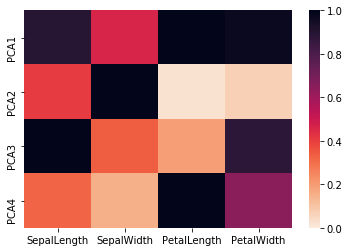

In [135]:
feature_importance1 = feature_importance.div(feature_importance.max(axis=1), axis=0)
sns.heatmap(feature_importance1, vmin=0, vmax=1, cmap=sns.cm.rocket_r)

In PCA1 features SepalLength, PetalLength and PetalWidth are the most important.  
in PCA2 feature feature SepalWidth is the most important.

In [136]:
spark.stop()